# Inference of Gene Regulatory Network using Kinetic Ising Model


In [1]:
from datetime import date

print("Last run date:", date.today())

Last run date: 2024-08-13


In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from pathlib import Path
import seaborn as sns
import os

import lib.NetAnalysis as na
import lib.fun_plotting as fun_plotting
from lib.ml_wrapper import asynch_reconstruction
import lib.figs_funcs as fig_func
import lib.funcs_general as funcs_general
import lib.funcs_ko as funcs_ko
# import lib.minibulk_funcs as mb

# Setting up matplotlib for LaTeX-style text rendering
%load_ext autoreload
%autoreload 2
# Uncomment the following lines during development for automatic module reloading
matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
matplotlib.rc('text', usetex=True)

# Information and Data Loading

In [3]:
# Define the base directory for code and data using pathlib for better path handling
base_dir = Path("/Users/cleliacorridori/Dropbox_2021 Dropbox/Jorah Mormont/GRN_Inference")
path = base_dir / "GRN_Inference_CODE"
path_data = base_dir / "DATA"


In [4]:
# genes of OUR dataset
genes_reference = np.loadtxt(path_data/"general_info/genes_order.csv", dtype="str") #selected genes

# time steps
time=["00h", "06h", "12h", "24h", "48h"]

# Classifying genes based on the Carbognin paper (2023)
naive = ["Klf4", "Klf2", "Esrrb", "Tfcp2l1", "Tbx3", "Stat3", "Nanog", "Sox2"]
formative_early = ["Nr0b1", "Zic3", "Rbpj"]
formative_late = ["Utf1", "Etv4", "Tcf15", "Dnmt3a", "Dnmt3b", "Lef1", "Otx2", "Pou3f1", "Etv5"]

# Identifying genes in the dataset that are not classified into the above categories
other = [x for x in genes_reference if x not in naive and x not in formative_early and x not in formative_late]


## Mini-Bulk Data + PST

In [5]:
# # load the Gene Expression data log normalized + Pseudo-Time: the columns are the cells and the rows are the genes
df_lN_mb_pst = pd.read_csv(path_data / "GE_data/processed/imp_genes_LogNorm_PST_MB.csv", header=0, index_col=0, sep=",")


## Binarized Data (Half-max)

In [6]:
spins_df_lN_mb_pst = pd.read_csv(path_data /"GE_data/processed/imp_genes_LogNorm_PST_MB_Spins.csv", header=0, index_col=0, sep=",")
plot_raster = False
if plot_raster:
    fig_func.raster_plot(np.array(spins_df_lN_mb_pst), 'Discretization of LogNorm data with Pseudotime Order', 1, genes_reference[::-1])
    plt.show()


## Randomization

In [7]:
spins_df_lN_mb_pst_shuffle = np.load(path_data / "GE_data/processed/imp_genes_LogNorm_PST_MB_Spins_RND50Test.npy")
 
Ntest = spins_df_lN_mb_pst_shuffle.shape[0] 
print("Number of tests (shuffled datasets)):", Ntest)

Number of tests (shuffled datasets)): 50


In [8]:
check=True
if check:
    # Check the reshuffle
    print(funcs_general.check_shuffle(spins_df_lN_mb_pst_shuffle, Ntest))


0.0


In [9]:
show = False
if show:
    for ii in range(0, Ntest, 60):
            fun_plotting.raster_plot(np.array(spins_df_lN_mb_pst_shuffle[ii,:,:]), 'Discretization of LogNorm data with PST - RND '+str(ii+1), 1, genes_reference[::-1])
            plt.show()    
            

## Known interactions

In [10]:
TPtrial_list = ["Stat3 Klf4 1", "Nanog Esrrb 1", "Stat3 Dnmt3b -1", 
                "Nanog Otx2 -1", "Nanog Pou3f1 -1",
                "Stat3 Gbx2 1", "Stat3 Tfcp2l1 1", 
                "Otx2 Pou3f1 1", "Otx2 Dnmt3a 1", 
                "Tcf7l1 Esrrb -1", "Tcf7l1 Klf2 -1", "Tcf7l1 Nanog -1", "Tcf7l1 Nr0b1 -1",  "Tcf7l1 Tfcp2l1 -1",  
                "Rbpj Nanog -1", "Rbpj Tbx3 -1", "Etv5 Lef1 1", "Etv5 Pou3f1 1"]


## Log2FC experimental data

### Leeb Data

In [11]:
df_KO_N24_Leeb_uncl = pd.read_csv(path_data/'Leeb_Data_Orig/df_KO_N24_uncleaned.csv', index_col=0, header=0)



### Kalkan data

In [12]:
df_tKO_Kalkan = pd.read_csv(path_data/'Kalkan_Data/df_tripleKO_diff.csv', index_col=0, header=0)


# Hyperparameter values

In [13]:
params = {"LAMBDA" : [0.01, 0.02, 0.03,0.04, 0.05, 0.07, 0.09],
          "lr"     : [0.8, 0.7, 0.6, 0.5, 0.4, 0.3],
          "drop"   : [0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99],
          "edrop"  : [15, 20, 25, 30, 35],
          "opt"    : ['MOMENTUM','NADAM'],
          "MOM"    : [0.75, 0.8, 0.85, 0.9, 0.95, 0.99],
          "reg"    : ['L1'],
          "Nepochs": [500, 700, 800, 900, 1200]}


# Results


In [14]:
interaction_thr = 0.0

# IGNITE RESULTS

In [16]:
## Loading Data for the model selection using the Fraction of correctly inferred interactions
Ntrials = 250
today = "noprior_2024_01_16" #"thr0_23_05_09" or other data
data_type = "pst_mb"

# LOADING data   
IGNITE_path = os.path.join(path_data, 'OUT_ISING', 'LogNORM', 'lN_arrays_' + data_type + '_' + str(today) + '.npz')
lN_arrays_sel = np.load(IGNITE_path)

lN_matx_sel = lN_arrays_sel['array_1']
lN_prec_sel = lN_arrays_sel['array_2']
lN_int_sel = lN_arrays_sel['array_3']
lN_dist_sel = lN_arrays_sel['array_4']

if lN_prec_sel.shape[0] != Ntrials:
    print("ERROR: the number of trials is not correct")

### FCI vs CMD

In [17]:
Nmodel_sel = 10 # Select the number of best models to analyse

# select models with highest lN_prec_sel_true, fraction of known interactions correctly inferred
print("FCI part")
interaction_thr = 0 # we consider all interactions, even with low values
idxs_sel_FCI = np.argsort(lN_prec_sel)[::-1][:Nmodel_sel]

for ii in idxs_sel_FCI:
    print ("selected indices for FCI:", ii,
           f"CIf value, {lN_prec_sel[ii]:.3f}",
           f"Distance value, {lN_dist_sel[ii]:.3f}")


print("CMD part")
# select models with lowest lN_dist, distance between Orig and Exp Pearson matrices
interaction_thr = 0 # we consider all interactions, even with low values
idxs_sel_CMD = np.argsort(lN_dist_sel)[:Nmodel_sel]

# for jj in idxs_sel_CMD:
#     print ("selected indices for CMD:", jj,
#            f"CIf value, {lN_prec_sel[jj]:.3f}",
#            f"Distance value, {lN_dist_sel[jj]:.3f}")

FCI part
selected indices for FCI: 117 CIf value, 0.778 Distance value, 0.534
selected indices for FCI: 154 CIf value, 0.778 Distance value, 0.614
selected indices for FCI: 229 CIf value, 0.778 Distance value, 0.630
selected indices for FCI: 56 CIf value, 0.778 Distance value, 0.710
selected indices for FCI: 208 CIf value, 0.778 Distance value, 0.545
selected indices for FCI: 77 CIf value, 0.778 Distance value, 0.712
selected indices for FCI: 33 CIf value, 0.778 Distance value, 0.519
selected indices for FCI: 92 CIf value, 0.778 Distance value, 0.560
selected indices for FCI: 167 CIf value, 0.778 Distance value, 0.655
selected indices for FCI: 119 CIf value, 0.778 Distance value, 0.560
CMD part
selected indices for CMD: 194 CIf value, 0.667 Distance value, 0.428
selected indices for CMD: 242 CIf value, 0.722 Distance value, 0.432
selected indices for CMD: 38 CIf value, 0.722 Distance value, 0.441
selected indices for CMD: 136 CIf value, 0.722 Distance value, 0.447
selected indices for 

### SELECTION of FCI or CMD method

In [18]:
# Decide which model selection we want to analyse
# CMD
idxs_sel = idxs_sel_CMD.copy()

# FCI
# idxs_sel = idxs_sel_FCI.copy()

print("Selected model indices:", idxs_sel)
# Nmodel_sel = len(idxs_sel)

ordered_idxs_sel = np.argsort(idxs_sel) # ordered indices
idxs_sel = idxs_sel[ordered_idxs_sel] # ordered indices



Selected model indices: [194 242  38 136 148 218 133  81  36 249]


## Models selected (by the preferred criteria, FCI or CMD)

/Users/cleliacorridori/Dropbox_2021 Dropbox/Jorah Mormont/GRN_Inference/GRN_Inference_CODE/lib/figs_funcs.py:189: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbarM.ax.set_yticklabels(cbarM.ax.get_yticklabels(), fontname='Avenir')


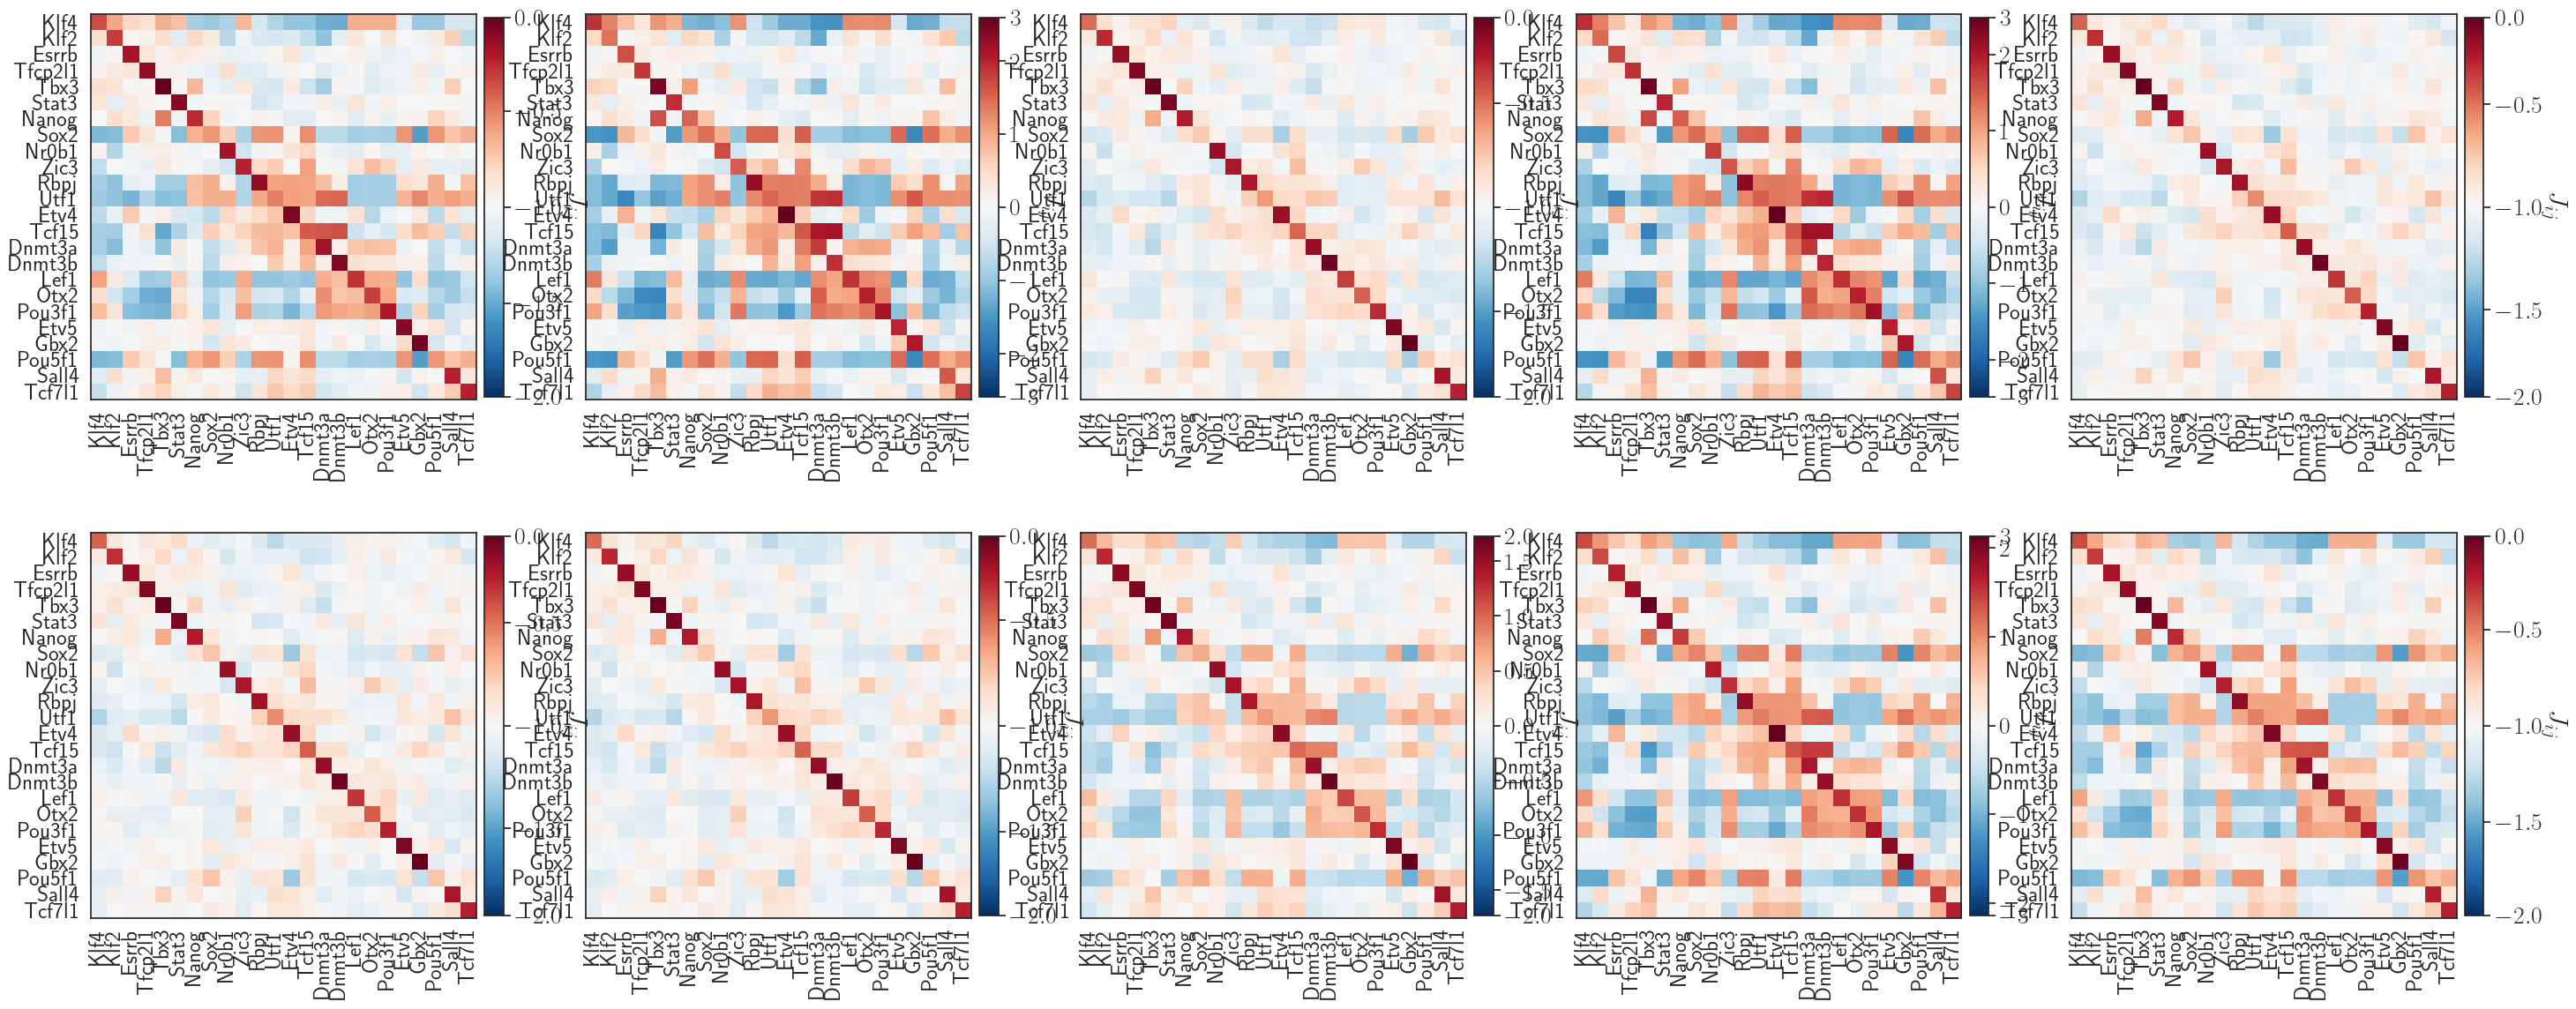

In [20]:
best_model_sel = np.zeros((Nmodel_sel, lN_matx_sel.shape[1], lN_matx_sel.shape[2]))

Nrow = 2
Ncol = Nmodel_sel // Nrow + (Nmodel_sel % 2 >0) #5
fig, ax = plt.subplots(nrows=Nrow, ncols=Ncol, figsize=(35, 14))

for ii in range(Nmodel_sel):
    best_model_sel[ii,:,:] = np.squeeze(lN_matx_sel[idxs_sel[ii],:,:])
    # plot the interaction matrices
    fig_func.plotmat(best_model_sel[ii,:,:], fig, ax[ii//Ncol, ii%Ncol], genes_reference, "", fix=False)

plt.show()

## Model Analysis

In [30]:
N_genes = spins_df_lN_mb_pst.shape[0]
N_ts = spins_df_lN_mb_pst.shape[1] 
N_sim = spins_df_lN_mb_pst_shuffle.shape[0] 
N_test_KO = N_sim

# to compute the distance between matrices we need the correlation matrices of shuffled data
cm_original_lN = np.corrcoef(spins_df_lN_mb_pst)
corr_matxs_rnd_lN = np.array([np.corrcoef(spins_df_lN_mb_pst_shuffle[i,:,:]) for i in range(N_sim)])
# distance for shuffled data
noise_dist = np.mean([funcs_ko.sum_squared_abs_diff(cm_original_lN, corr_matxs_rnd_lN[i,:,:]) for i in range(N_sim)])


Model Selection: Trial  36 
params:  {'LAMBDA': 0.05, 'lr': 0.4, 'drop': 0.7, 'edrop': 20, 'opt': 'NADAM', 'MOM': 0.99, 'reg': 'L1', 'Nepochs': 700}
{'LAMBDA': 0.05, 'lr': 0.4, 'drop': 0.7, 'edrop': 20, 'opt': 'NADAM', 'MOM': 0.99, 'reg': 'L1', 'Nepochs': 700}
Epoch 	 Max J gradient 	 Max h gradient 	 Max change in J 	 Max change in h 	 Likelihood
300 	 0.009581 	 0.000701 	 0.0002 	 0.0001 	 -5.1044
600 	 0.009324 	 0.000681 	 0.0 	 0.0 	 -5.0791


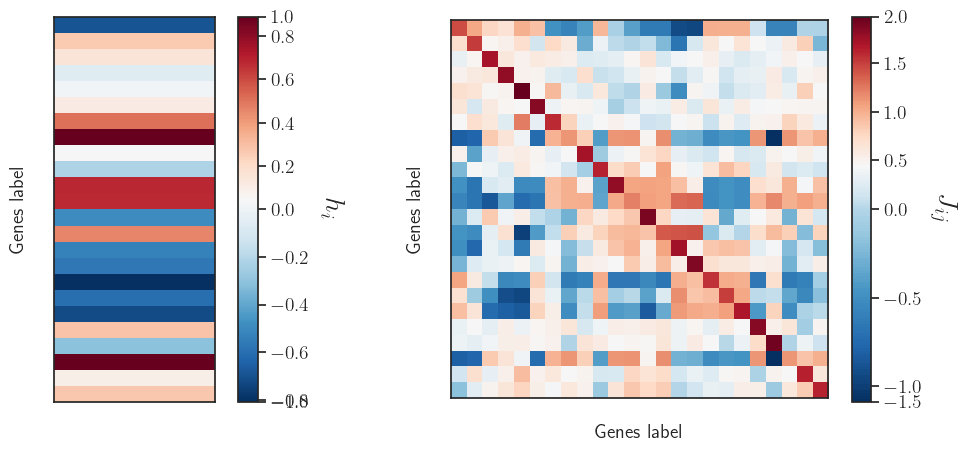

Fraction of correctly inferred interactions: 0.72, distance: 0.45
Model Selection: Trial  38 
params:  {'LAMBDA': 0.03, 'lr': 0.6, 'drop': 0.7, 'edrop': 20, 'opt': 'NADAM', 'MOM': 0.95, 'reg': 'L1', 'Nepochs': 500}
{'LAMBDA': 0.03, 'lr': 0.6, 'drop': 0.7, 'edrop': 20, 'opt': 'NADAM', 'MOM': 0.95, 'reg': 'L1', 'Nepochs': 500}
Epoch 	 Max J gradient 	 Max h gradient 	 Max change in J 	 Max change in h 	 Likelihood
300 	 0.003955 	 0.000788 	 0.0004 	 0.0001 	 -7.6559


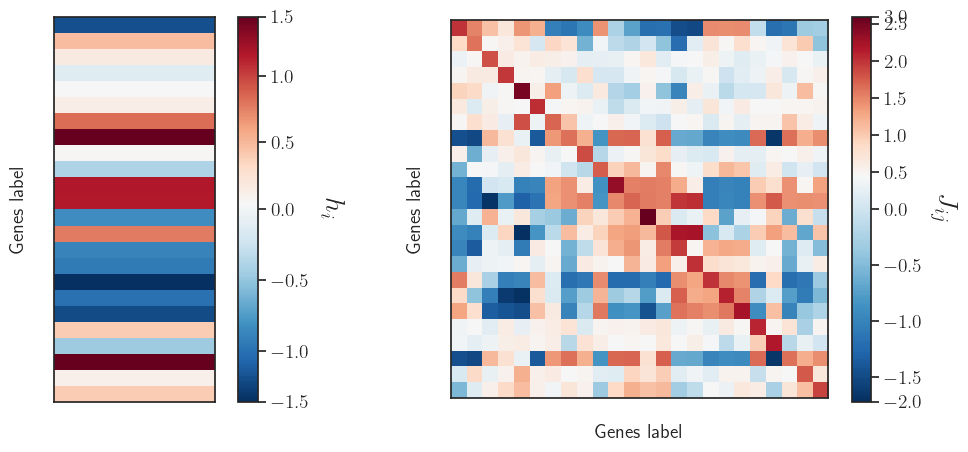

Fraction of correctly inferred interactions: 0.72, distance: 0.44
Model Selection: Trial  81 
params:  {'LAMBDA': 0.09, 'lr': 0.3, 'drop': 0.65, 'edrop': 30, 'opt': 'NADAM', 'MOM': 0.75, 'reg': 'L1', 'Nepochs': 800}
{'LAMBDA': 0.09, 'lr': 0.3, 'drop': 0.65, 'edrop': 30, 'opt': 'NADAM', 'MOM': 0.75, 'reg': 'L1', 'Nepochs': 800}
Epoch 	 Max J gradient 	 Max h gradient 	 Max change in J 	 Max change in h 	 Likelihood
300 	 0.015658 	 0.002904 	 0.0002 	 0.0001 	 -3.0183
600 	 0.014537 	 0.002788 	 0.0 	 0.0 	 -3.0273


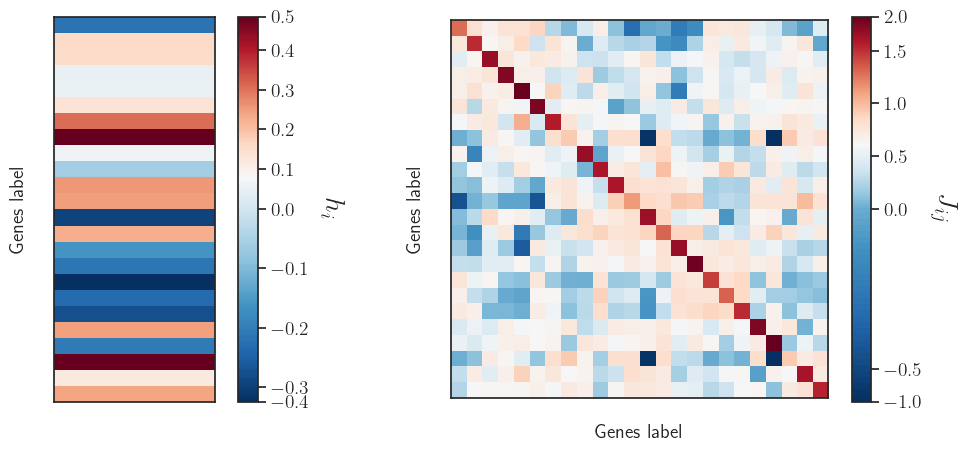

Fraction of correctly inferred interactions: 0.67, distance: 0.45
Model Selection: Trial  133 
params:  {'LAMBDA': 0.03, 'lr': 0.7, 'drop': 0.7, 'edrop': 20, 'opt': 'NADAM', 'MOM': 0.95, 'reg': 'L1', 'Nepochs': 900}
{'LAMBDA': 0.03, 'lr': 0.7, 'drop': 0.7, 'edrop': 20, 'opt': 'NADAM', 'MOM': 0.95, 'reg': 'L1', 'Nepochs': 900}
Epoch 	 Max J gradient 	 Max h gradient 	 Max change in J 	 Max change in h 	 Likelihood
300 	 0.004095 	 0.000779 	 0.0004 	 0.0001 	 -7.4109
600 	 0.003905 	 0.000777 	 0.0 	 0.0 	 -7.3551
900 	 0.003903 	 0.000777 	 0.0 	 0.0 	 -7.3548


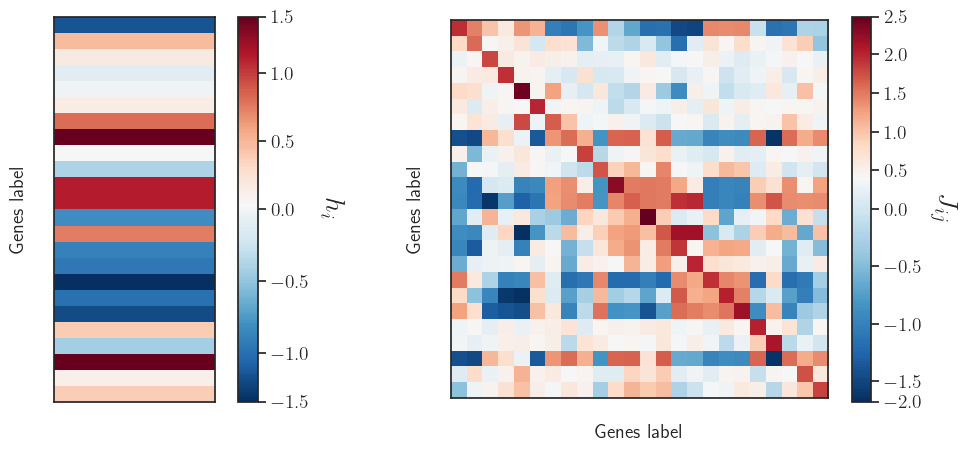

Fraction of correctly inferred interactions: 0.72, distance: 0.45
Model Selection: Trial  136 
params:  {'LAMBDA': 0.09, 'lr': 0.6, 'drop': 0.7, 'edrop': 25, 'opt': 'NADAM', 'MOM': 0.9, 'reg': 'L1', 'Nepochs': 1200}
{'LAMBDA': 0.09, 'lr': 0.6, 'drop': 0.7, 'edrop': 25, 'opt': 'NADAM', 'MOM': 0.9, 'reg': 'L1', 'Nepochs': 1200}
Epoch 	 Max J gradient 	 Max h gradient 	 Max change in J 	 Max change in h 	 Likelihood
300 	 0.014818 	 0.002951 	 0.0002 	 0.0001 	 -2.8706
600 	 0.013373 	 0.002713 	 0.0 	 0.0 	 -2.902
900 	 0.013314 	 0.002703 	 0.0 	 0.0 	 -2.9034
1200 	 0.013312 	 0.002703 	 0.0 	 0.0 	 -2.9035


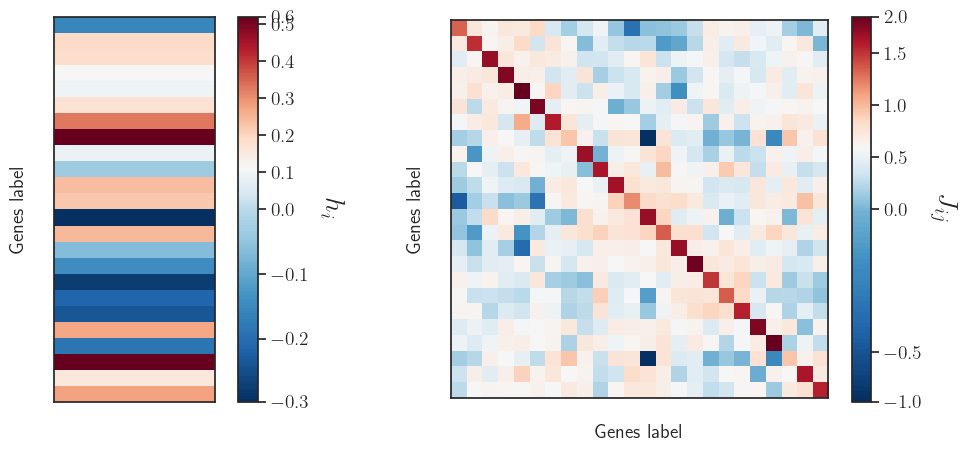

Fraction of correctly inferred interactions: 0.72, distance: 0.45
Model Selection: Trial  148 
params:  {'LAMBDA': 0.09, 'lr': 0.6, 'drop': 0.7, 'edrop': 25, 'opt': 'NADAM', 'MOM': 0.85, 'reg': 'L1', 'Nepochs': 900}
{'LAMBDA': 0.09, 'lr': 0.6, 'drop': 0.7, 'edrop': 25, 'opt': 'NADAM', 'MOM': 0.85, 'reg': 'L1', 'Nepochs': 900}
Epoch 	 Max J gradient 	 Max h gradient 	 Max change in J 	 Max change in h 	 Likelihood
300 	 0.014818 	 0.002951 	 0.0002 	 0.0001 	 -2.8706
600 	 0.013373 	 0.002713 	 0.0 	 0.0 	 -2.902
900 	 0.013314 	 0.002703 	 0.0 	 0.0 	 -2.9034


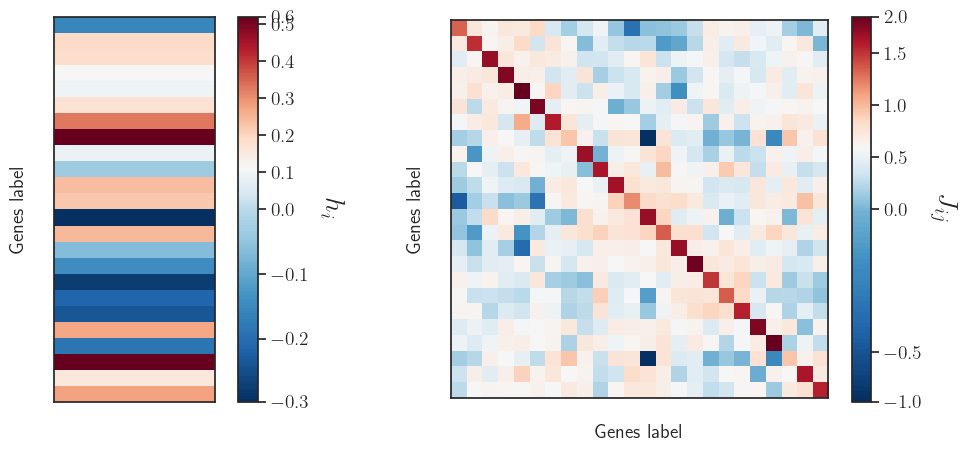

Fraction of correctly inferred interactions: 0.72, distance: 0.45
Model Selection: Trial  194 
params:  {'LAMBDA': 0.09, 'lr': 0.8, 'drop': 0.65, 'edrop': 20, 'opt': 'NADAM', 'MOM': 0.75, 'reg': 'L1', 'Nepochs': 1200}
{'LAMBDA': 0.09, 'lr': 0.8, 'drop': 0.65, 'edrop': 20, 'opt': 'NADAM', 'MOM': 0.75, 'reg': 'L1', 'Nepochs': 1200}
Epoch 	 Max J gradient 	 Max h gradient 	 Max change in J 	 Max change in h 	 Likelihood
300 	 0.017013 	 0.003393 	 0.0001 	 0.0 	 -2.8742
600 	 0.016694 	 0.00334 	 0.0 	 0.0 	 -2.8799
900 	 0.016693 	 0.003339 	 0.0 	 0.0 	 -2.88
1200 	 0.016693 	 0.003339 	 0.0 	 0.0 	 -2.88
early stopping implemented at epoch:  1200


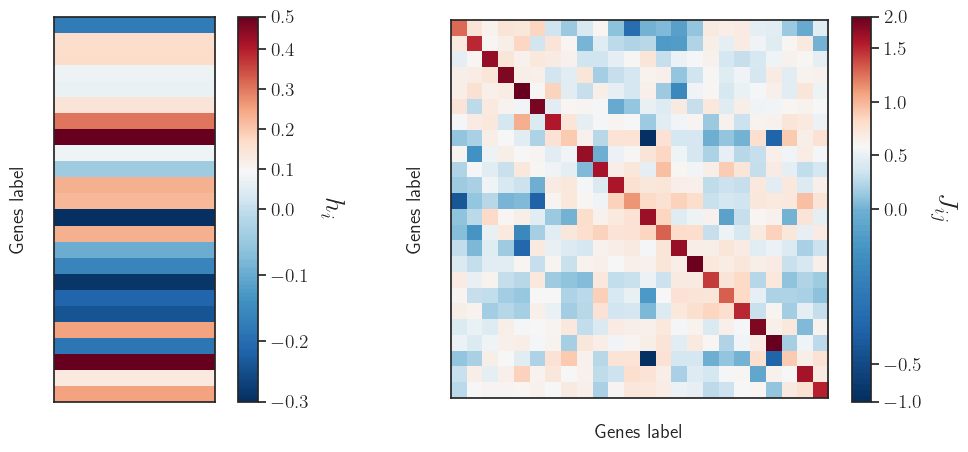

Fraction of correctly inferred interactions: 0.67, distance: 0.43
Model Selection: Trial  218 
params:  {'LAMBDA': 0.09, 'lr': 0.6, 'drop': 0.65, 'edrop': 15, 'opt': 'NADAM', 'MOM': 0.95, 'reg': 'L1', 'Nepochs': 500}
{'LAMBDA': 0.09, 'lr': 0.6, 'drop': 0.65, 'edrop': 15, 'opt': 'NADAM', 'MOM': 0.95, 'reg': 'L1', 'Nepochs': 500}
Epoch 	 Max J gradient 	 Max h gradient 	 Max change in J 	 Max change in h 	 Likelihood
300 	 0.020647 	 0.001488 	 0.0 	 0.0 	 -3.9875


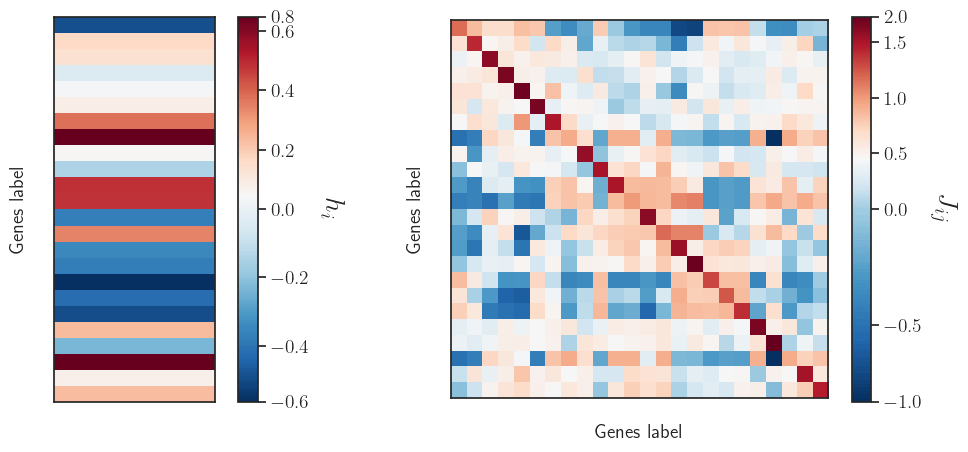

Fraction of correctly inferred interactions: 0.72, distance: 0.45
Model Selection: Trial  242 
params:  {'LAMBDA': 0.04, 'lr': 0.3, 'drop': 0.7, 'edrop': 20, 'opt': 'NADAM', 'MOM': 0.8, 'reg': 'L1', 'Nepochs': 1200}
{'LAMBDA': 0.04, 'lr': 0.3, 'drop': 0.7, 'edrop': 20, 'opt': 'NADAM', 'MOM': 0.8, 'reg': 'L1', 'Nepochs': 1200}
Epoch 	 Max J gradient 	 Max h gradient 	 Max change in J 	 Max change in h 	 Likelihood
300 	 0.005299 	 0.000811 	 0.0002 	 0.0001 	 -6.0056
600 	 0.005184 	 0.000812 	 0.0 	 0.0 	 -5.9812
900 	 0.005182 	 0.000812 	 0.0 	 0.0 	 -5.9811
1200 	 0.005182 	 0.000812 	 0.0 	 0.0 	 -5.9811


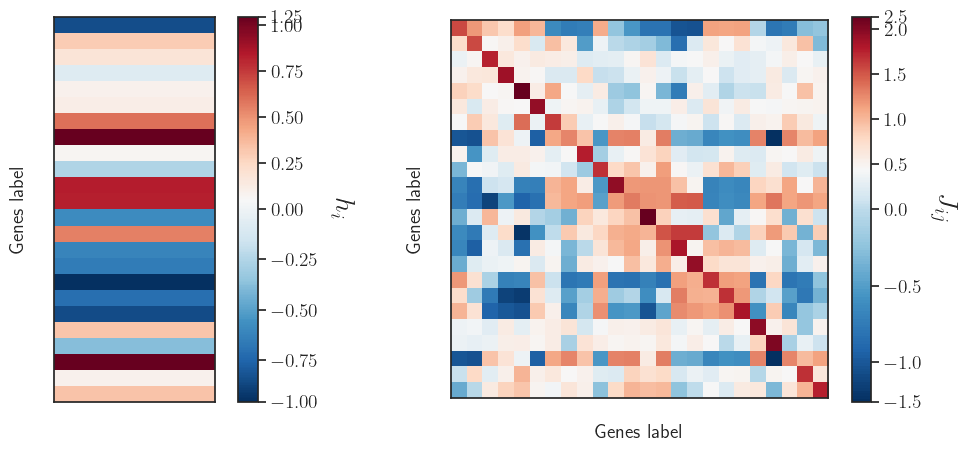

Fraction of correctly inferred interactions: 0.72, distance: 0.43
Model Selection: Trial  249 
params:  {'LAMBDA': 0.05, 'lr': 0.4, 'drop': 0.7, 'edrop': 20, 'opt': 'NADAM', 'MOM': 0.85, 'reg': 'L1', 'Nepochs': 700}
{'LAMBDA': 0.05, 'lr': 0.4, 'drop': 0.7, 'edrop': 20, 'opt': 'NADAM', 'MOM': 0.85, 'reg': 'L1', 'Nepochs': 700}
Epoch 	 Max J gradient 	 Max h gradient 	 Max change in J 	 Max change in h 	 Likelihood
300 	 0.009581 	 0.000701 	 0.0002 	 0.0001 	 -5.1044
600 	 0.009324 	 0.000681 	 0.0 	 0.0 	 -5.0791


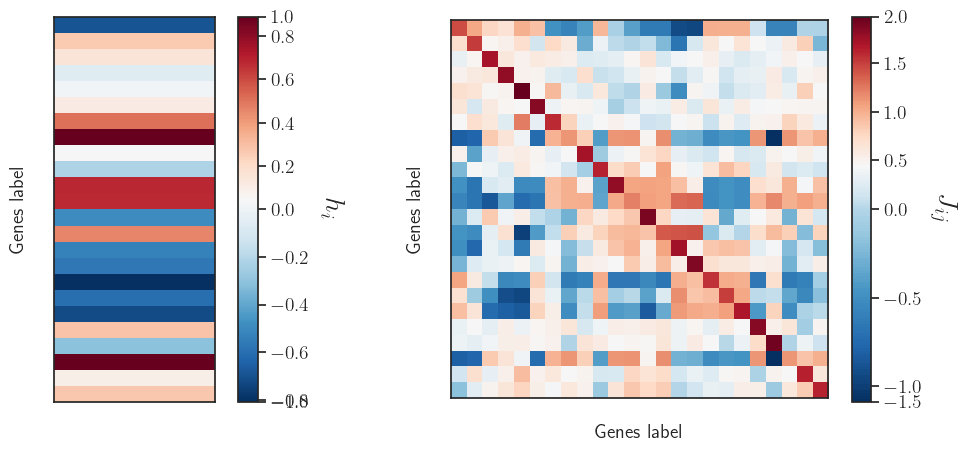

Fraction of correctly inferred interactions: 0.72, distance: 0.45


In [31]:
models_selected =[] 
spins_new_lN = np.zeros((len(idxs_sel),N_genes, N_ts, N_sim))
cm_sim_lN = np.zeros((spins_new_lN.shape[0], spins_new_lN.shape[1], spins_new_lN.shape[1], spins_new_lN.shape[3])) # we save it, delete if not needed
cm_sim_lN_mean = np.zeros((spins_new_lN.shape[0], spins_new_lN.shape[1], spins_new_lN.shape[1]))
np.random.seed(20961) 
cc = 0 
for ii in range(Ntrials):
    par_sel = {}
    for jj in params.keys():
        par_sel[jj] = np.random.choice(params[jj])
        
    if ii in idxs_sel:   
        print("Model Selection: Trial ", ii, "\nparams: ", par_sel)
        print(par_sel)
        # model
        model_temp = asynch_reconstruction(np.array(spins_df_lN_mb_pst), delta_t = 1, LAMBDA = par_sel["LAMBDA"], opt = par_sel['opt'], MOM=par_sel["MOM"], reg = 'L1')
        model_temp.reconstruct(np.array(spins_df_lN_mb_pst), Nepochs = par_sel["Nepochs"], start_lr = par_sel["lr"], drop = par_sel["drop"], edrop = par_sel["edrop"])

        print("Fraction of correctly inferred interactions: {:.2f}, distance: {:.2f}".format(lN_prec_sel[ii], lN_dist_sel[ii]))
        models_selected.append(model_temp)   
        
        # evaluate the model with the comparison between original and simulated Pearson correlation matrix:
        for ll in range(N_sim):
            # GENERATING DATA: generate N_sim new time series of spins using model
            spins_new_lN[cc,:,:,ll] = model_temp.generate_samples(seed=ll*2, t_size=N_ts)
            # compute the Pearson correlation matrix
            cm_sim_lN[cc,:,:, ll] = np.corrcoef(spins_new_lN[cc,:,:,ll])
        cm_sim_lN_mean[cc, :, :] = np.nanmean(cm_sim_lN[cc,:,:,:], axis=2) # averaging simulated correlation matrices
        cc += 1
        
    

### Correlation Matrices Comparison (sperimental vs generated data)

In [32]:
KO_goodness_sel = np.zeros((len(idxs_sel), 4))
dist  = np.zeros(Ntrials)

cc=0
for ii in range(Ntrials):        
    if ii in idxs_sel:
        print("Model Selection: Trial ", idxs_sel[cc])
        print("Fraction of correctly inferred interactions: {:.2f}, distance: {:.2f}".format(lN_prec_sel[ii], lN_dist_sel[ii]))
             
        # Single KO
        # Rbpj
        diff_lN_Rbpj, exp_logFC_Rbpj, KO_genes_reference_Rbpj = funcs_ko.KO_wrap("Rbpj", 
                                                                             best_model_sel[cc,:,:], 
                                                                             models_selected[cc], genes_reference, 
                                                                             spins_new_lN[cc,:,:,:], 
                                                                             df_KO_N24_Leeb_uncl,
                                                                             N_test_KO=N_test_KO) 
        
        diff_lN_Etv5, exp_logFC_Etv5, KO_genes_reference_Etv5 = funcs_ko.KO_wrap("Etv5", 
                                                                             best_model_sel[cc,:,:], 
                                                                             models_selected[cc], genes_reference, 
                                                                             spins_new_lN[cc,:,:,:], 
                                                                             df_KO_N24_Leeb_uncl, 
                                                                             N_test_KO=N_test_KO)
        
        diff_lN_Tcf7l1, exp_logFC_Tcf7l1, KO_genes_reference_Tcf7l1 = funcs_ko.KO_wrap("Tcf7l1", 
                                                                             best_model_sel[cc,:,:], 
                                                                             models_selected[cc], genes_reference, 
                                                                             spins_new_lN[cc,:,:,:], 
                                                                             df_KO_N24_Leeb_uncl, 
                                                                             N_test_KO=N_test_KO)

        # Triple KO
        KO_gene_T_spins = ["Rbpj", "Etv5", "Tcf7l1"]
        KO_lN_rec_matx_T_spins, KO_lN_rec_field_T_spins, KO_gene_idk_T, KO_genes_reference_T = funcs_ko.info_KO(best_model_sel[cc,:,:], 
                                                                                                                models_selected[cc], KO_gene_T_spins,
                                                                                                                genes_order=genes_reference, 
                                                                                                                multiple=True) # For triple KO
        # remove row of the KO genes
        wt_lN_mb_pst_spins_forKO_T = np.delete(np.array(spins_new_lN[cc,:,:,:]),KO_gene_idk_T, axis=0)

        # generate KO activity and compute the average KO and WT activity
        KO_T_weighted_avg, KO_T_weighted_std, wt_T_avg, wt_T_std, KO_T_spins = funcs_ko.KO_avg_weighted(KO_lN_rec_matx_T_spins, 
                                                                                                        KO_lN_rec_field_T_spins, 
                                                                                                        wt_lN_mb_pst_spins_forKO_T,
                                                                                                        N_test_KO=N_test_KO, N_time=N_ts)

        # remove row of the KO from EXPERIMENTAL DATA
        df_tKO_Kalkan_sel =df_tKO_Kalkan.drop(["Etv5","Rbpj", "Tcf7l1"])
        # search gene present in genes_reference and absent in df_tKO_Kalkan_sel and thei indices
        common_genes = [x for x in KO_genes_reference_T if x in df_tKO_Kalkan_sel.index]
        common_genes_idx = [x for x in range(len(KO_genes_reference_T)) if KO_genes_reference_T[x] in df_tKO_Kalkan_sel.index]
        # select only simulated KO and WT for which we know experimental tKO
        KO_T_weighted_avg_sel_T = KO_T_weighted_avg[common_genes_idx]
        KO_T_weighted_std_sel_T = KO_T_weighted_std[common_genes_idx]
        wt_T_avg_sel_T = wt_T_avg[common_genes_idx]
        wt_T_std_sel_T = wt_T_std[common_genes_idx]

        diff_sim_T = funcs_ko.KO_diff_sim(KO_T_weighted_avg_sel_T, KO_T_weighted_std_sel_T ,wt_T_avg_sel_T, wt_T_std_sel_T)

        # Normalizing differences and log2FC
        diff_sim   = np.array([diff_lN_Rbpj, diff_lN_Etv5, diff_lN_Tcf7l1])
        log2FC_exp = np.array([exp_logFC_Rbpj, exp_logFC_Etv5, exp_logFC_Tcf7l1]) # ONLY for single KO experimental data
        genes_KOs  = np.array([KO_genes_reference_Rbpj, KO_genes_reference_Etv5, KO_genes_reference_Tcf7l1])
        # Simulated data:
        diff_max = max(np.abs(diff_sim).max(), np.abs(diff_sim_T).max())        
        diff_sim_norm = diff_sim/diff_max
        diff_sim_T_norm = diff_sim_T/diff_max
        # Experimental data:
        log2FC_exp_norm = log2FC_exp/np.abs(log2FC_exp).max() # ONLY for single KO experimental data
        df_tKO_Kalkan_norm = df_tKO_Kalkan_sel/np.abs(df_tKO_Kalkan_sel).max() # TRIPLE KO experimental data

        diff_thr = 0.05
        # Rbpj
        # funcs_ko.KO_heat_comparison_T(diff_sim_norm[0,:], log2FC_exp_norm[0,:], "Rbpj", genes_KOs[0,:], Norm=False)
        print(funcs_ko.fraction_agreement(diff_sim_norm[0,:], log2FC_exp_norm[0,:], genes_KOs[0,:], diff_thr))
        KO_goodness_sel[cc,0] = funcs_ko.fraction_agreement(diff_sim_norm[0,:], log2FC_exp_norm[0,:], genes_KOs[0,:], diff_thr)[3]
        # Etv5
        # funcs_ko.KO_heat_comparison_T(diff_sim_norm[1,:], log2FC_exp_norm[1,:], "Etv5", genes_KOs[0,:], Norm=False)
        print(funcs_ko.fraction_agreement(diff_sim_norm[1,:], log2FC_exp_norm[1,:], genes_KOs[1,:], diff_thr))
        KO_goodness_sel[cc,1] = funcs_ko.fraction_agreement(diff_sim_norm[1,:], log2FC_exp_norm[1,:], genes_KOs[1,:], diff_thr)[3]

        # Tcf7l1
        # funcs_ko.KO_heat_comparison_T(diff_sim_norm[2,:], log2FC_exp_norm[2,:], "Tcf7l1", genes_KOs[0,:], Norm=False)
        print(funcs_ko.fraction_agreement(diff_sim_norm[2,:], log2FC_exp_norm[2,:], genes_KOs[2,:], diff_thr))
        KO_goodness_sel[cc,2] = funcs_ko.fraction_agreement(diff_sim_norm[2,:], log2FC_exp_norm[2,:], genes_KOs[2,:], diff_thr)[3]

        # Triple
        # funcs_ko.KO_heat_comparison_T(diff_sim_T_norm, np.array(df_tKO_Kalkan_sel).squeeze(), "", np.array(common_genes), Norm=False)
        print(funcs_ko.fraction_agreement(diff_sim_T_norm, np.array(df_tKO_Kalkan_norm).squeeze(), np.array(common_genes), diff_thr))
        KO_goodness_sel[cc,3] = funcs_ko.fraction_agreement(diff_sim_T_norm, np.array(df_tKO_Kalkan_norm).squeeze(), np.array(common_genes), diff_thr)[3]
        
        
        cc+=1


Model Selection: Trial  36
Fraction of correctly inferred interactions: 0.72, distance: 0.45
(0.30434782608695654, 0.30434782608695654, 0.043478260869565216, 0.6521739130434783)
(0.30434782608695654, 0.34782608695652173, 0.08695652173913043, 0.7391304347826086)
(0.08695652173913043, 0.17391304347826086, 0.043478260869565216, 0.30434782608695654)
(0.3333333333333333, 0.2857142857142857, 0.047619047619047616, 0.6666666666666667)
Model Selection: Trial  38
Fraction of correctly inferred interactions: 0.72, distance: 0.44
(0.30434782608695654, 0.30434782608695654, 0.043478260869565216, 0.6521739130434783)
(0.2608695652173913, 0.34782608695652173, 0.043478260869565216, 0.6521739130434783)
(0.08695652173913043, 0.17391304347826086, 0.043478260869565216, 0.30434782608695654)
(0.3333333333333333, 0.2857142857142857, 0.047619047619047616, 0.6666666666666667)
Model Selection: Trial  81
Fraction of correctly inferred interactions: 0.67, distance: 0.45
(0.30434782608695654, 0.30434782608695654, 0.

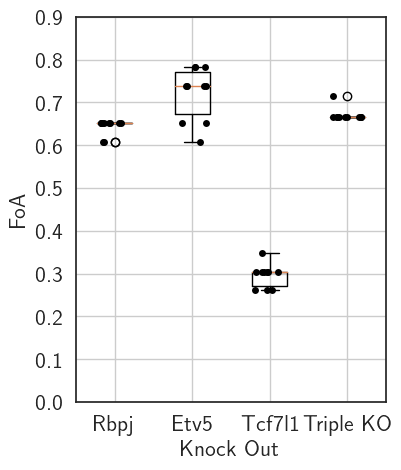

In [33]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(4, 5))
positions = range(0, 4)
figs_path = "/Users/cleliacorridori/Dropbox_2021 Dropbox/Jorah Mormont/GRN_Inference/FIG"

# Create the box plot
boxplot = ax.boxplot(KO_goodness_sel, showmeans=False, positions=positions) # Showing the median
# Add individual value markers
stripplot = sns.stripplot(data=KO_goodness_sel, color='black', jitter=0.2, dodge=True, ax=ax)

ax.set_xticks(positions)
ax.set_xticklabels(['Rbpj', 'Etv5', 'Tcf7l1', 'Triple KO'], fontsize=16)
ax.set_yticks(np.arange(0,1,0.1))
ax.set_yticklabels(np.round(np.arange(0,1,0.1),2), fontsize=16)
ax.set_xlabel('Knock Out', fontsize=16)
ax.set_ylabel('FoA', fontsize=16)
ax.set_title('', fontsize=18)

# showing the mean
show_mean = False
if show_mean:
    mean_marker = dict(marker='o', markerfacecolor='blue', markersize=7)
    for mean in boxplot['means']:
        mean.set(**mean_marker)
    plt.legend([boxplot['means'][0]], ['Mean'], fontsize=12, loc='lower left')
    
plt.grid()
plt.savefig(figs_path + "/IGNITE_ModelSelection_FoA_KOs.svg", transparent=True, bbox_inches='tight', format='svg')

plt.show()    


In [34]:
KO_goodness_sel.shape
# Save the results KO_goodness_sel
np.save(path_data / "OUT_ISING/LogNORM/KO_goodness_top10.npy", KO_goodness_sel)